## LDA - 제품 리뷰(한국어)

## 1. 환경설정

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
!apt-get update
!apt-get install -y openjdk-11-jdk
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 https://cli.github.com/packages stable InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,130 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packag

In [11]:
# 나눔 폰트 설치: 한글 폰트 사용을 위해 설치 후 런타임 재시작 필요할 수 있음
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 폰트 설정
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 22 fonts, 0 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/dejavu: skipping, looped directory detected
/usr/share/fonts/truetyp

In [ ]:
!pip install gensim
!pip install konlpy

In [28]:
import pandas as pd
import numpy as np
from konlpy.tag import Okt
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from pprint import pprint
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

In [29]:
data = pd.read_table('/content/gdrive/MyDrive/Colab Notebooks (1)/BigData/naver_shopping.txt', header= None)
data.columns = ['Id','Review']

In [30]:
data

,Id,Review
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


In [31]:
from sklearn.model_selection import train_test_split

# train/test 80:20 비율로 나누기
train_data, test_data = train_test_split(data, test_size=0.2, random_state=123)

## 2. 데이터 전처리

In [32]:
# 코퍼스 만들기
documents = train_data['Review'].to_list()
documents = [doc for doc in documents if isinstance(doc, str)]  # 텍스트가 없는 문서 제외
documents = [re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc) for doc in documents]  # 한국어만 고려
# 한국어 없는 문서 제외
korean_pattern = re.compile("[ㄱ-ㅎㅏ-ㅣ가-힣]+")
documents = [doc for doc in documents if korean_pattern.search(doc)]
# 한국어가 없는 텍스트 제외
print("문서 개수:", len(documents))
print("첫번째 문서:", documents[0])

문서 개수: 160000
첫번째 문서: 애들이 만들고 놀다 분리시켜놨지만 좋아오 ㅈ


In [33]:
# 코퍼스의 문서 단어 단위 토큰화
okt = Okt()
doc_tokenized = [okt.nouns(doc) for doc in documents]
doc_tokenized = [[word for word in doc_tokens if len(word) >= 2] for doc_tokens in doc_tokenized]
print("첫번째 문서 토큰화 결과:", doc_tokenized[0])

첫번째 문서 토큰화 결과: ['분리']


In [34]:
dictionary = corpora.Dictionary(doc_tokenized)
# 적어도 5번 이상 출현한 단어
# 적당히 출현한 단어만 단어집으로 고려
dictionary.filter_extremes(no_below=5, no_above=0.2)

BoW_corpus = [dictionary.doc2bow(doc) for doc in doc_tokenized]

print("단어집(vocabulary) 단어 수:", len(dictionary))
print("문서 수:", len(BoW_corpus))

단어집(vocabulary) 단어 수: 7854
문서 수: 160000


## 3. LDA 모델 적용
* 토픽수 $K=20$
* 학습데이터(코퍼스) $V=9152, D=148740$
* 하이퍼파라미터 $\alpha$, $\beta$는 값을 $1/K=0.05$

In [35]:
lda_model = LdaModel(corpus=BoW_corpus, id2word=dictionary, num_topics=20, random_state=123)

* 토픽별 단어 분포 $\phi_k$

In [36]:
# 토픽별 단어 분포 행렬
topic_word_dist_mat = lda_model.get_topics()

print("토픽별 중요한 단어 순서대로 표현:")
pprint(lda_model.print_topics())

토픽별 중요한 단어 순서대로 표현:
[(0,
  '0.158*"하나" + 0.123*"느낌" + 0.054*"일단" + 0.045*"고정" + 0.034*"케이스" + '
  '0.031*"배송비" + 0.029*"비닐" + 0.028*"엉망" + 0.022*"색도" + 0.020*"손잡이"'),
 (1,
  '0.168*"상품" + 0.133*"조금" + 0.063*"조립" + 0.048*"착용" + 0.047*"기분" + 0.040*"문제" '
  '+ 0.034*"설명" + 0.028*"그대로" + 0.026*"다만" + 0.021*"연결"'),
 (2,
  '0.455*"배송" + 0.120*"포장" + 0.064*"아이" + 0.056*"상태" + 0.039*"제품" + 0.018*"사람" '
  '+ 0.015*"자주" + 0.015*"가방" + 0.014*"이용" + 0.012*"파손"'),
 (3,
  '0.094*"다른" + 0.080*"바로" + 0.049*"하루" + 0.043*"원래" + 0.039*"정도" + 0.035*"기대" '
  '+ 0.034*"지금" + 0.030*"오늘" + 0.029*"일주일" + 0.029*"제품"'),
 (4,
  '0.137*"효과" + 0.049*"충전" + 0.044*"커서" + 0.035*"모양" + 0.035*"소재" + 0.034*"바닥" '
  '+ 0.030*"애기" + 0.030*"얼굴" + 0.025*"전이" + 0.024*"고무"'),
 (5,
  '0.122*"구입" + 0.060*"불량" + 0.055*"후기" + 0.035*"걱정" + 0.032*"먼지" + 0.032*"고민" '
  '+ 0.031*"의사" + 0.028*"모두" + 0.024*"보고" + 0.023*"후회"'),
 (6,
  '0.166*"냄새" + 0.101*"사진" + 0.034*"제대로" + 0.033*"사서" + 0.032*"금방" + '
  '0.030*"구멍" + 0.029*"거의" + 0.028*

* 특정 토픽의 단어 분포 시각화

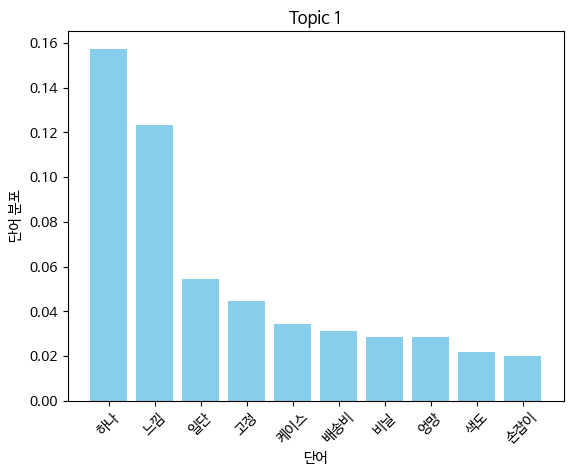

In [37]:
topic_idx = 0
topic_dist = topic_word_dist_mat[topic_idx]
sorted_indices = np.argsort(topic_dist)[::-1]
words = [dictionary[idx] for idx in sorted_indices[:10]]
probs = topic_dist[sorted_indices[:10]]
plt.figure()
plt.bar(words, probs, color='skyblue')
plt.title("Topic {}".format(topic_idx + 1))
plt.xlabel("단어")
plt.ylabel("단어 분포")
plt.xticks(rotation=45)
plt.show()

* '하나', '느낌', '일단' 같은 소비자들의 주관적인 만족도 표현 토픽이 보임
* 소비자들이 본인의 주관적인 느낌을 공유함
* 제품의 구체적인 특성보다 전반적 만족도에 대한 표현이 우세함

* 문서별 토픽분포

In [38]:
# 문서별 토픽 분포
doc_topic_dist = lda_model[BoW_corpus]
print("첫번째 문서의 토픽 분포의 간단한 표현:")
pprint(list(doc_topic_dist)[0])

# 문서별 토픽 분포 행렬
doc_topic_dist_mat = np.zeros(shape=(len(doc_topic_dist), lda_model.num_topics), dtype=float)
for doc_idx, doc_topics in enumerate(doc_topic_dist):
    for topic_idx, topic_weight in doc_topics:
        doc_topic_dist_mat[doc_idx, topic_idx] = topic_weight

print("첫번째 문서의 토픽 분포:")
pprint(np.round(doc_topic_dist_mat[0,:], 3))

첫번째 문서의 토픽 분포의 간단한 표현:
[(0, np.float32(0.025000434)),
 (1, np.float32(0.025000434)),
 (2, np.float32(0.025000434)),
 (3, np.float32(0.52499217)),
 (4, np.float32(0.025000434)),
 (5, np.float32(0.025000434)),
 (6, np.float32(0.025000434)),
 (7, np.float32(0.025000434)),
 (8, np.float32(0.025000434)),
 (9, np.float32(0.025000434)),
 (10, np.float32(0.025000434)),
 (11, np.float32(0.025000434)),
 (12, np.float32(0.025000434)),
 (13, np.float32(0.025000434)),
 (14, np.float32(0.025000434)),
 (15, np.float32(0.025000434)),
 (16, np.float32(0.025000434)),
 (17, np.float32(0.025000434)),
 (18, np.float32(0.025000434)),
 (19, np.float32(0.025000434))]
첫번째 문서의 토픽 분포:
array([0.025, 0.025, 0.025, 0.525, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025])


* 첫번째 문서가 토픽 4에 속할 확률이 가장 높음

* 특정 문서의 토픽 분포 시각화

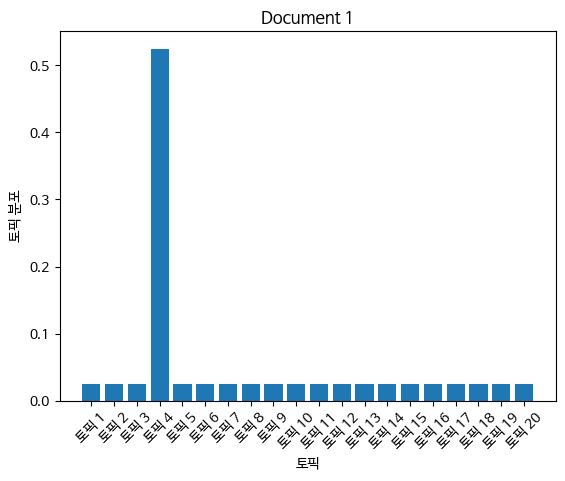

In [39]:
doc_idx = 0
probs = doc_topic_dist_mat[doc_idx,:]
plt.bar(['토픽 ' + str(topic_idx+1) for topic_idx in range(lda_model.num_topics)], probs)
plt.title("Document {}".format(doc_idx + 1))
plt.xlabel("토픽")
plt.ylabel("토픽 분포")
plt.xticks(rotation=45)
plt.show()

In [41]:
# 토픽 4의 주요 키워드 보기
print("토픽 4의 주요 키워드")
topic_4_words = lda_model.show_topic(3, topn=15)  # 상위 15개 단어
for word, prob in topic_4_words:
    print(f"{word}: {prob:.4f}")

# 첫 번째 리뷰 내용 확인
print("\n첫 번째 리뷰 내용")
print(data.iloc[0]['Review'])

# 토픽 4에 강하게 속하는 다른 리뷰들도 보기
print("\n토픽 4에 속하는 대표 리뷰들")
topic_4_strong = []
for idx in range(len(doc_topic_dist_mat)):
    if doc_topic_dist_mat[idx, 3] > 0.4:  # 40% 이상
        topic_4_strong.append((idx, doc_topic_dist_mat[idx, 3]))

# 확률 높은 순으로 정렬해서 상위 5개
topic_4_strong.sort(key=lambda x: x[1], reverse=True)
for idx, prob in topic_4_strong[:5]:
    print(f"\n확률: {prob:.2%}")
    print(f"리뷰: {data.iloc[idx]['Review'][:100]}...")  # 앞 100자만

토픽 4의 주요 키워드
다른: 0.0941
바로: 0.0798
하루: 0.0493
원래: 0.0431
정도: 0.0395
기대: 0.0355
지금: 0.0338
오늘: 0.0295
일주일: 0.0291
제품: 0.0285
운동: 0.0237
용량: 0.0221
사은: 0.0216
광고: 0.0204
마리: 0.0194

첫 번째 리뷰 내용
배공빠르고 굿

토픽 4에 속하는 대표 리뷰들

확률: 86.43%
리뷰: 아버님 진작에 사드릴껄~너무 좋아하셔요^^...

확률: 81.00%
리뷰: 괜찮습니당 만족해요...

확률: 81.00%
리뷰: 레몬은 맛있는데 체리는 제 취향이 아니네요 하나 먹고 지인 줬어요 필드 트위스트가 그래도 제일 맛있는 거 같아요...

확률: 81.00%
리뷰: 아주좋아요 좋은데 후두부쪽이찍찍이라 별루네요...

확률: 81.00%
리뷰: 배송이 빠르네요. 항상 먹던것이라 없으면 불안합니다. 잘 먹을게요...


## 4. 토픽모델 평가
### 1. 혼란도

In [42]:
print("학습데이터 로그 혼란도:", lda_model.log_perplexity(BoW_corpus))

학습데이터 로그 혼란도: -11.040957199700738


In [17]:
# 시험데이터 코퍼스 만들기
# 학습데이터와 전처리 똑같이 하기
documents_test = test_data['Review'].to_list()
documents_test = [doc for doc in documents_test if isinstance(doc, str)]
documents_test = [re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc) for doc in documents_test]
korean_pattern = re.compile("[ㄱ-ㅎㅏ-ㅣ가-힣]+")
documents_test = [doc for doc in documents_test if korean_pattern.search(doc)]
print("시험데이터 문서 개수:", len(documents_test))
print("시험데이터 두번째 문서:", documents_test[1])

# 시험데이터 코퍼스의 문서 단어 단위 토큰화
okt = Okt()
doc_tokenized_test = [okt.nouns(doc) for doc in documents_test]
doc_tokenized_test = [[word for word in doc_tokens if len(word) >= 2] for doc_tokens in doc_tokenized_test]
print("시험데이터 두번째 문서 토큰화 결과:", doc_tokenized_test[1])

시험데이터 문서 개수: 40000
시험데이터 두번째 문서: 배송일주일만에옴
시험데이터 두번째 문서 토큰화 결과: ['배송', '일주일']


In [18]:
# dictionary 는 시험데이터로 다시 만드는 것이 아니라 학습데이터와 동일해야 함
# dictionary.doc2bow의 기본값은 allow_update=False여야 함
BoW_corpus_test = [dictionary.doc2bow(doc) for doc in doc_tokenized_test]
print("시험데이터 로그 혼란도:", lda_model.log_perplexity(BoW_corpus_test))

시험데이터 로그 혼란도: -11.15238168032383


* 학습데이터 혼란도와 시험데이터 혼란도가 비슷함 -> 과적합 없음
* 하지만 혼란도만으로는 토픽의 의미적 품질을 알 수 없음 -> 응집성지수 계산 필요

### 2. 응집성지수
* 시험데이터를 응집성지수를 계산하기 위한 코퍼스로 활용
* 토픽별로 중요한 $M=10$개의 단어를 이용

In [19]:
coherence_model = CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='u_mass', topn=10) # 텍스트 대신 코퍼스를 받을수도 있음
print("토픽별 UMass 응집성지수", coherence_model.get_coherence_per_topic())
print("UMass 응집성지수", coherence_model.get_coherence())

토픽별 UMass 응집성지수 [np.float64(-8.749784765124023), np.float64(-5.739760662501192), np.float64(-7.377260240123306), np.float64(-4.450419354231339), np.float64(-11.069743656551376), np.float64(-6.602985908416003), np.float64(-7.172791952157761), np.float64(-4.948362929039624), np.float64(-9.198194760055745), np.float64(-9.167526826967938), np.float64(-4.470540026639799), np.float64(-10.703768764170741), np.float64(-11.322616260129495), np.float64(-6.028514817009939), np.float64(-7.0524191783755885), np.float64(-8.090731272996273), np.float64(-10.414527728863849), np.float64(-6.831574816217129), np.float64(-6.323438738657259), np.float64(-8.833268480797146)]
UMass 응집성지수 -7.727411556951277


In [20]:
coherence_model = CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='c_v', topn=10, window_size=110) # 단어의 연속된 110개의 단어 고려, 텍스트에 시험데이터의 코퍼스를 넣어준다
print("토픽별 C_v 응집성지수", coherence_model.get_coherence_per_topic())
print("C_v 응집성지수", coherence_model.get_coherence())

토픽별 C_v 응집성지수 [np.float64(0.24783381622578457), np.float64(0.4458415849780179), np.float64(0.35197218139578307), np.float64(0.4742747433276861), np.float64(0.23442744377311656), np.float64(0.35173929225423656), np.float64(0.30294925759672575), np.float64(0.5287305257991426), np.float64(0.2620795447611856), np.float64(0.21484019190687004), np.float64(0.5151418243109558), np.float64(0.2705011053634357), np.float64(0.3275630679321474), np.float64(0.3728238034378773), np.float64(0.2909062063229298), np.float64(0.17007273010482474), np.float64(0.2621425439467234), np.float64(0.2885545979536249), np.float64(0.34681994952028095), np.float64(0.29062411354656703)]
C_v 응집성지수 0.3274919262228958


In [21]:
coherence_model = CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='c_uci', topn=10,
                                        window_size=10)
print("토픽별 UCI 응집성지수", coherence_model.get_coherence_per_topic())
print("UCI 응집성지수", coherence_model.get_coherence())

토픽별 UCI 응집성지수 [np.float64(-3.616319274647439), np.float64(-1.1903656228031578), np.float64(-2.90684677002554), np.float64(-0.07632943627186344), np.float64(-5.683813996652356), np.float64(-2.502265039876681), np.float64(-2.1118067021477436), np.float64(-0.12631186111171167), np.float64(-3.8945005142094002), np.float64(-3.9744133565394653), np.float64(-0.32761776987439), np.float64(-5.277057335201885), np.float64(-5.8293240800982), np.float64(-1.5175088742146698), np.float64(-2.1364190327228174), np.float64(-3.111871954979784), np.float64(-5.1936741719801525), np.float64(-2.280685389289586), np.float64(-1.3043587438641218), np.float64(-3.6740314389027935)]
UCI 응집성지수 -2.836776068270688


* UCI 응집성 지수는 괜찮은 편이지만 C_v 응집성 지수는 개선이 필요
* 토픽의 개수 조정, 전처리 개선, LDA 파라미터 조정 드의 방법을 고려해 볼 수 있음

## 5. 적절한 토픽 개수의 선택

In [22]:
log_perplexity = []
umass = []
cv = []
uci = []

topic_range = [5,10,15,20,25,30,35,40,50,60,70,80,90,100,150,200]
for num_topics in topic_range:    # 토픽 개수별 혼란도와 응집성지수 저정 (시간 다소 소요)
    # 해당 토픽 개수로 LDA 학습
    lda_model = LdaModel(corpus=BoW_corpus, id2word=dictionary, num_topics=num_topics, random_state=123)

    # 시험데이터 코퍼스로 평가한 혼란도, 응집성지수 저장
    log_perplexity.append(lda_model.log_perplexity(BoW_corpus_test))
    coherence_model = CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='u_mass', topn=10)
    umass.append(coherence_model.get_coherence())
    coherence_model = CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='c_v', topn=10, window_size=110)
    cv.append(coherence_model.get_coherence())
    coherence_model = CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='c_uci', topn=10, window_size=10)
    uci.append(coherence_model.get_coherence())

### 1. 혼란도 기준

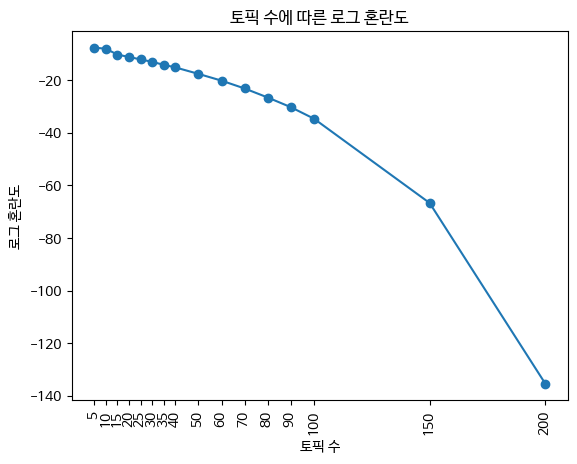

최적의 토픽 수: 200


In [23]:
plt.plot(topic_range, log_perplexity, marker='o')
plt.xlabel("토픽 수")
plt.ylabel("로그 혼란도")
plt.title("토픽 수에 따른 로그 혼란도")
plt.xticks(topic_range)
plt.xticks(rotation=90)  # x축 레이블 회전
plt.show()

# 최적의 토픽수 찾기
optimal_num_topics = topic_range[log_perplexity.index(min(log_perplexity))]
print("최적의 토픽 수:", optimal_num_topics)

* 그래프의 특징:
  * 토픽 수가 증가할 수록 혼란도가 계속 감소

* 문제점:
  * 토픽이 많을수록 무조건 좋다는건 과적합 위험이 있다는 것
  * 혼란도만으로는 최적의 토픽 수를 정하기 어려움

### 2. UMass 응집성지수 기준

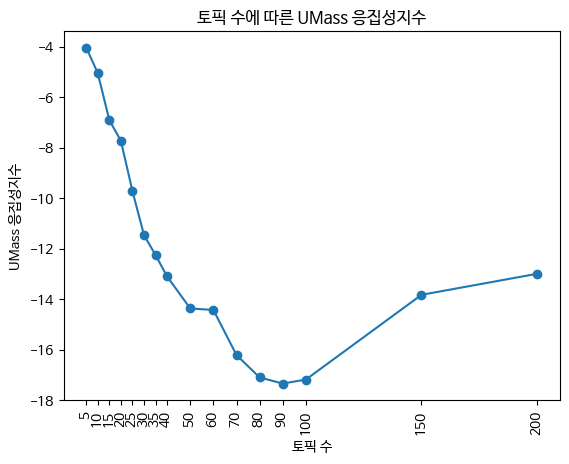

최적의 토픽 수: 5


In [24]:
plt.plot(topic_range, umass, marker='o')
plt.xlabel("토픽 수")
plt.ylabel("UMass 응집성지수")
plt.title("토픽 수에 따른 UMass 응집성지수")
plt.xticks(topic_range)
plt.xticks(rotation=90)
plt.show()

# 최적의 토픽 수 찾기
optimal_num_topics = topic_range[umass.index(max(umass))]
print("최적의 토픽 수:", optimal_num_topics)

* 그래프의 특징:
  * 5개의 토픽에서 최고점
  * 이후 계속 하락하다가 90-100 부근에서 다시 상승

* 문제점:
  * 5개의 토픽은 너무 적음(세분화 부족)

### 3. UCI 응집성지수 기준

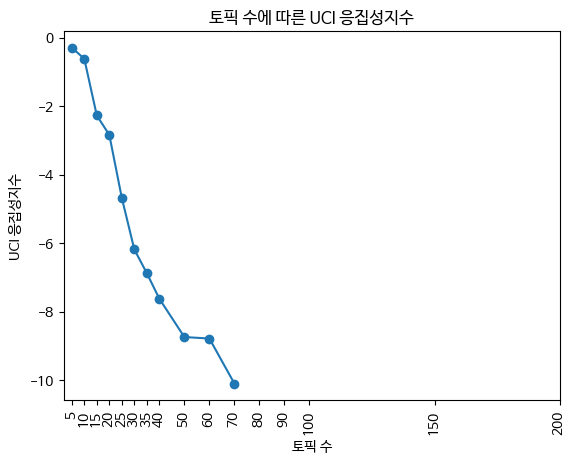

최적의 토픽 수: 80


In [25]:
plt.plot(topic_range, uci, marker='o')
plt.xlabel("토픽 수")
plt.ylabel("UCI 응집성지수")
plt.title("토픽 수에 따른 UCI 응집성지수")
plt.xticks(topic_range)
plt.xticks(rotation=90)
plt.show()

# 최적의 토픽 수 찾기
optimal_num_topics = topic_range[uci.index(max(uci))]
print("최적의 토픽 수:", optimal_num_topics)

* 그래프의 특징:
  * 토픽 60~80개에서 최저점

### 4. C_v 응집성지수 기준

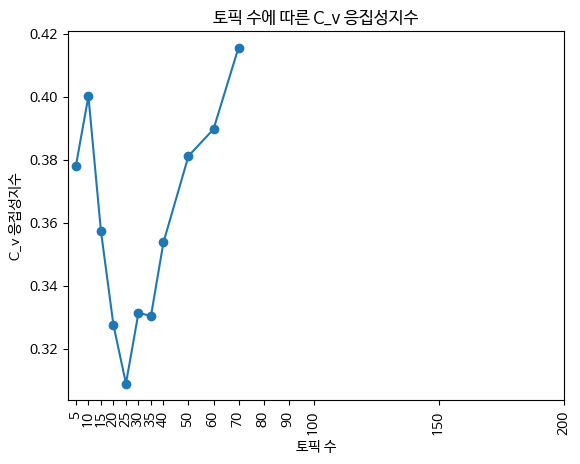

최적의 토픽 수: 70


In [26]:
plt.plot(topic_range, cv, marker='o')
plt.xlabel("토픽 수")
plt.ylabel("C_v 응집성지수")
plt.title("토픽 수에 따른 C_v 응집성지수")
plt.xticks(topic_range)
plt.xticks(rotation=90)                                        # x축 레이블 회전
plt.show()

# 최적의 토픽 수 찾기
optimal_num_topics = topic_range[cv.index(max(cv))]
print("최적의 토픽 수:", optimal_num_topics)

* 그래프의 특징:
  * 토픽 70개에서 최고점
  * 15~20개 부근에서도 국지적 피크

> C_v 응집성 지수가 가장 신뢰할 만한 지표로서 추천 토픽 개수는 70개

### 6. LDA 모델 적용

In [43]:
lda_model = LdaModel(corpus=BoW_corpus, id2word=dictionary, num_topics=70, random_state=123)

In [44]:
print("학습데이터 로그 혼란도:", lda_model.log_perplexity(BoW_corpus))
BoW_corpus_test = [dictionary.doc2bow(doc) for doc in doc_tokenized_test]
print("시험데이터 로그 혼란도:", lda_model.log_perplexity(BoW_corpus_test))

학습데이터 로그 혼란도: -23.23380632673653
시험데이터 로그 혼란도: -23.131015429332127


In [45]:
coherence_model = CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='u_mass', topn=10)
print("토픽별 UMass 응집성지수", coherence_model.get_coherence_per_topic())
print("UMass 응집성지수", coherence_model.get_coherence())

토픽별 UMass 응집성지수 [np.float64(-11.368784705357282), np.float64(-17.267374217218954), np.float64(-16.227103064660724), np.float64(-13.673060253936951), np.float64(-17.291432615818294), np.float64(-19.361340831068546), np.float64(-14.121692088581485), np.float64(-19.254994544773815), np.float64(-14.638957791273016), np.float64(-15.668267844173247), np.float64(-18.047162043839794), np.float64(-18.61481970228865), np.float64(-14.932366088306644), np.float64(-18.49746492960439), np.float64(-16.220807192627994), np.float64(-17.277478959267142), np.float64(-18.94580484263687), np.float64(-17.680345645442646), np.float64(-19.13431070292622), np.float64(-17.658614346265416), np.float64(-19.269105810557374), np.float64(-16.258691246039927), np.float64(-16.262725986341184), np.float64(-16.194266653867814), np.float64(-16.780419376880538), np.float64(-12.945312384182747), np.float64(-17.359878038798406), np.float64(-15.376060802911912), np.float64(-19.79636206691107), np.float64(-18.05390991952497),

In [46]:
coherence_model = CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='c_v', topn=10, window_size=110)
print("토픽별 C_v 응집성지수", coherence_model.get_coherence_per_topic())
print("C_v 응집성지수", coherence_model.get_coherence())

토픽별 C_v 응집성지수 [np.float64(0.34610220355504306), np.float64(0.4508448116665428), np.float64(0.4445235076648274), np.float64(0.32992347774838665), np.float64(0.4142000752226542), np.float64(0.5299432318400877), np.float64(0.3696608751370677), np.float64(0.5111422656265683), np.float64(0.33897603726148856), np.float64(0.41655058025946523), np.float64(0.47043653302352234), np.float64(0.4871205379264187), np.float64(0.37821226554597986), np.float64(0.5024393336581554), np.float64(0.3948314440360021), np.float64(0.4103628773146279), np.float64(0.4848807540054966), np.float64(0.49208754111120057), np.float64(0.5254959550438214), np.float64(0.44938190377504544), np.float64(0.5107695492190875), np.float64(0.42163590273212453), np.float64(0.39437763325866604), np.float64(0.3923460553831569), np.float64(0.436222115613755), np.float64(0.31610095674872035), np.float64(0.4202985425388735), np.float64(0.34524829989146333), np.float64(0.5374512441315373), np.float64(0.47456847986971307), np.float64(0.

In [47]:
coherence_model = CoherenceModel(model=lda_model, texts=doc_tokenized_test, coherence='c_uci', topn=10,
                                        window_size=10)
print("토픽별 UCI 응집성지수", coherence_model.get_coherence_per_topic())
print("UCI 응집성지수", coherence_model.get_coherence())

토픽별 UCI 응집성지수 [np.float64(-5.640443459031443), np.float64(-10.98971875707218), np.float64(-10.994289045294982), np.float64(-7.7212150428014334), np.float64(-10.657424982050646), np.float64(-13.065901762639509), np.float64(-8.779306425351566), np.float64(-12.850269663195203), np.float64(-8.96150355872437), np.float64(-9.686388043444067), np.float64(-11.733867887822951), np.float64(-12.339463937739238), np.float64(-9.431895175353233), np.float64(-11.656241824310005), np.float64(-10.046832505156958), np.float64(-11.53861560960393), np.float64(-12.310777542680405), np.float64(-11.769083113218583), np.float64(-12.631565603591898), np.float64(-11.251791122158437), np.float64(-12.938198444770652), np.float64(-9.956321447344502), np.float64(-9.409349143737483), np.float64(-10.398161624572042), np.float64(-11.136470568802073), np.float64(-7.560221055599706), np.float64(-11.331046422381087), np.float64(-8.713238179811844), np.float64(-13.558998665676459), np.float64(-11.970146587754488), np.floa

* 1. 혼란도
  * 학습데이터 -11.04 -> -23.23
  * 시험데이터 -11.15 -> -23.13
  * 개선됨
* 2. UMASS 응집성계수
  * -7.73 -> -16.21
  * 0에 가까울수록 좋은값인데 0에서 더 멀어짐
* 3. C_v 응집성계수
  * 0.327 -> 0.416
  * 0.4 이상 달성으로 개선됨
* 4. UCI 응집성계수
  * -2.84 -> -10.10
  * 악회됨

> 혼란도와 C_v 응집성계수의 대폭 개선으로 모델이 데이터의 패턴은 더 잘 학습하지만 토픽이 70개로 해석이 매우 어려움